In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDPMPipeline,DDIMScheduler
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms  
from tqdm.auto import tqdm
import pytorch_lightning as pl

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 载入一个预训练管线
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
pipeline = DDPMPipeline.from_pretrained(pipeline_name).to(device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
# 使用DDIM调度器，仅用40步生成一些图片
scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)

In [5]:
# 将随机噪声作为出发点
x = torch.randn(8,3,256,256).to(device)

0it [00:00, ?it/s]

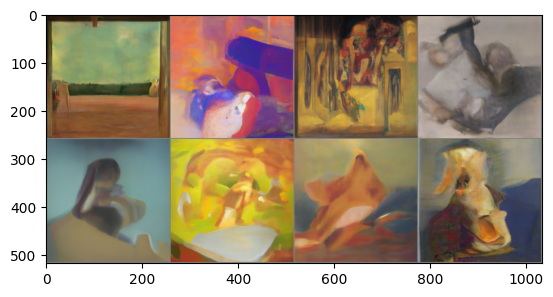

In [6]:
# 使用一个简单的采样循环
for i,t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x,t)
    with torch.no_grad():
        noise_pred = pipeline.unet(model_input,t)['sample']
    x = scheduler.step(noise_pred,t,x).prev_sample
# 查看生成结果
grid = torchvision.utils.make_grid(x,nrow=4)
plt.imshow(grid.permute(1,2,0).cpu().clip(-1,1) * 0.5 + 0.5)

In [7]:
# 定义一个基于颜色差异值的引导损失函数
def color_loss(images, target_color=(0.1, 0.9, 0.5)):
    # 将目标颜色映射到(-1, 1)的范围
    target = (
        torch.tensor(target_color).to(images.device) * 2 - 1
    )  # Map target color to (-1, 1)
    target = target[
        None, :, None, None
    ]  # 获取一个形状为(1, 3, 1, 1)的张量，以便与图像进行广播
    error = torch.abs(
        images - target
    ).mean()  # 计算每个像素的绝对误差，然后取平均值
    return error

0it [00:00, ?it/s]

Epoch 0 loss: 28.02
Epoch 1 loss: 24.42
Epoch 2 loss: 21.56
Epoch 3 loss: 19.57
Epoch 4 loss: 17.79
Epoch 5 loss: 16.38
Epoch 6 loss: 14.83
Epoch 7 loss: 13.07
Epoch 8 loss: 11.79
Epoch 9 loss: 10.98
Epoch 10 loss: 10.60
Epoch 11 loss: 10.32
Epoch 12 loss: 10.19
Epoch 13 loss: 10.02
Epoch 14 loss: 9.92
Epoch 15 loss: 9.89
Epoch 16 loss: 9.86
Epoch 17 loss: 9.87
Epoch 18 loss: 9.88
Epoch 19 loss: 9.90
Epoch 20 loss: 9.92
Epoch 21 loss: 9.94
Epoch 22 loss: 9.96
Epoch 23 loss: 9.98
Epoch 24 loss: 9.99
Epoch 25 loss: 10.01
Epoch 26 loss: 10.02
Epoch 27 loss: 10.04
Epoch 28 loss: 10.05
Epoch 29 loss: 10.07
Epoch 30 loss: 10.08
Epoch 31 loss: 10.10
Epoch 32 loss: 10.11
Epoch 33 loss: 10.12
Epoch 34 loss: 10.14
Epoch 35 loss: 10.17
Epoch 36 loss: 10.21
Epoch 37 loss: 10.24
Epoch 38 loss: 10.28
Epoch 39 loss: 10.29


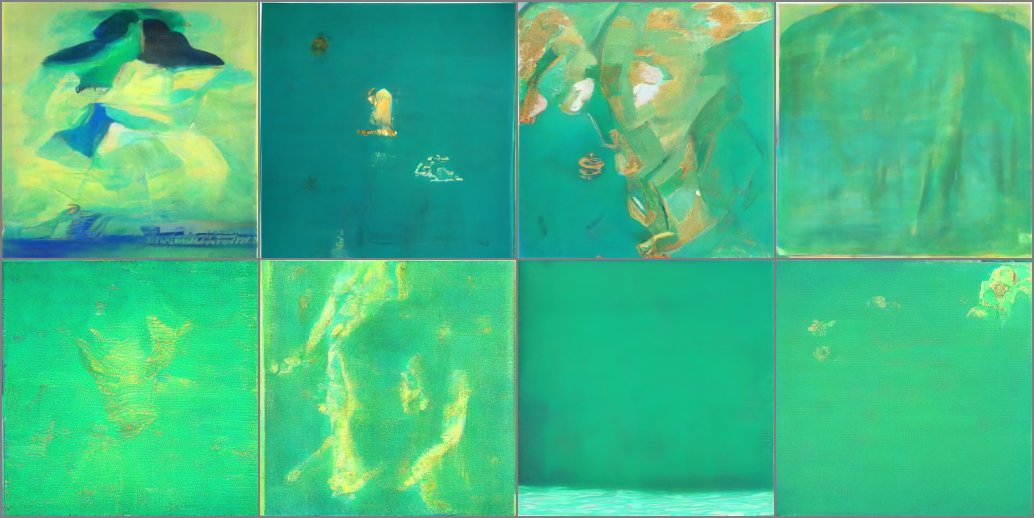

In [9]:
guide_loss_scale = 40 # 指定引导的强度
x = torch.randn(8,3,256,256).to(device)
losses = []
# 使用一个简单的采样循环
for i,t in tqdm(enumerate(scheduler.timesteps)):
    # 准备模型输入
    model_input = scheduler.scale_model_input(x,t)
    # 预测噪声
    with torch.no_grad():
        noise_pred = pipeline.unet(model_input,t)['sample']
    # 设置x的计算图为需要梯度
    x = x.detach().requires_grad_()
    # 得到“去噪”后的图片
    x0 = scheduler.step(noise_pred,t,x).pred_original_sample
    # 计算损失值
    loss = color_loss(x0) * guide_loss_scale
    losses.append(loss.item())
    # 计算梯度
    cond_grad = -torch.autograd.grad(loss,x)[0]
    # 使用梯度更新x
    x = x.detach() + cond_grad
    # 使用调度器更新x
    x = scheduler.step(noise_pred,t,x).prev_sample
    print(f"Epoch {i} loss: {loss.item():.2f}")
# 查看生成结果
grid = torchvision.utils.make_grid(x,nrow=4)
im = grid.permute(1,2,0).cpu().clip(-1,1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255,dtype=np.uint8))

Text(0.5, 1.0, 'Loss over time')

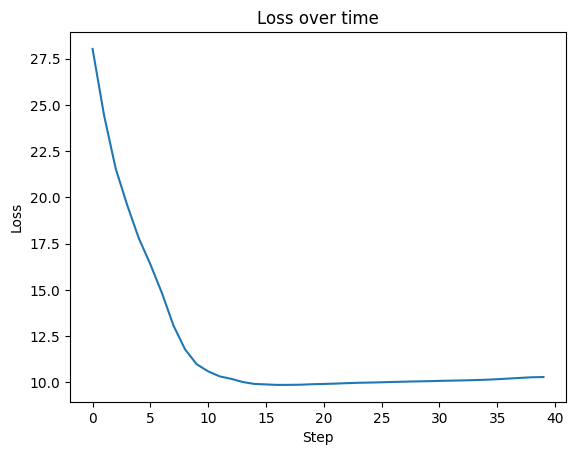

In [10]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss over time")

0it [00:00, ?it/s]

Epoch 0 loss: 30.22
Epoch 1 loss: 28.63
Epoch 2 loss: 27.14
Epoch 3 loss: 26.26
Epoch 4 loss: 25.66
Epoch 5 loss: 25.25
Epoch 6 loss: 25.07
Epoch 7 loss: 24.90
Epoch 8 loss: 24.81
Epoch 9 loss: 24.75
Epoch 10 loss: 24.65
Epoch 11 loss: 24.60
Epoch 12 loss: 24.58
Epoch 13 loss: 24.52
Epoch 14 loss: 24.48
Epoch 15 loss: 24.49
Epoch 16 loss: 24.47
Epoch 17 loss: 24.48
Epoch 18 loss: 24.49
Epoch 19 loss: 24.51
Epoch 20 loss: 24.52
Epoch 21 loss: 24.53
Epoch 22 loss: 24.54
Epoch 23 loss: 24.55
Epoch 24 loss: 24.56
Epoch 25 loss: 24.57
Epoch 26 loss: 24.58
Epoch 27 loss: 24.59
Epoch 28 loss: 24.60
Epoch 29 loss: 24.61
Epoch 30 loss: 24.62
Epoch 31 loss: 24.63
Epoch 32 loss: 24.64
Epoch 33 loss: 24.64
Epoch 34 loss: 24.65
Epoch 35 loss: 24.66
Epoch 36 loss: 24.67
Epoch 37 loss: 24.68
Epoch 38 loss: 24.69
Epoch 39 loss: 24.69


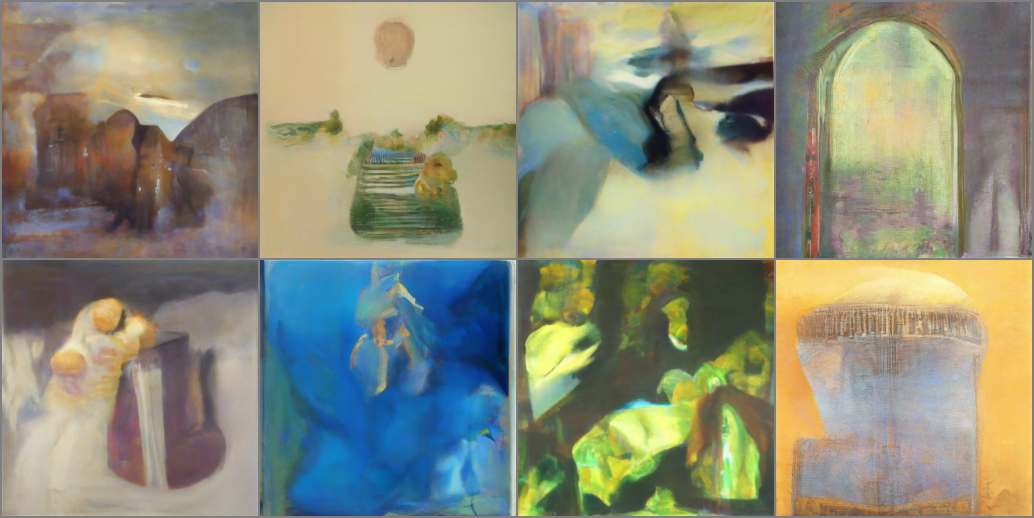

In [11]:
guide_loss_scale = 40 # 指定引导的强度
x = torch.randn(8,3,256,256).to(device)
losses = []
# 使用一个简单的采样循环
for i,t in tqdm(enumerate(scheduler.timesteps)):
    # 首先设置好x的计算图为需要梯度
    x = x.detach().requires_grad_()
    # 准备模型输入
    model_input = scheduler.scale_model_input(x,t)
    # 预测噪声
    noise_pred = pipeline.unet(model_input,t)['sample']
    # 得到“去噪”后的图片
    x0 = scheduler.step(noise_pred,t,x).pred_original_sample
    # 计算损失值
    loss = color_loss(x0) * guide_loss_scale
    losses.append(loss.item())
    # 计算梯度
    cond_grad = -torch.autograd.grad(loss,x)[0]
    # 根据梯度修改x
    x = x.detach() + cond_grad
    # 使用调度器更新x
    x = scheduler.step(noise_pred,t,x).prev_sample
    print(f"Epoch {i} loss: {loss.item():.2f}")
# 查看生成结果
grid = torchvision.utils.make_grid(x,nrow=4)
im = grid.permute(1,2,0).cpu().clip(-1,1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255,dtype=np.uint8))

Text(0.5, 1.0, 'Loss over time')

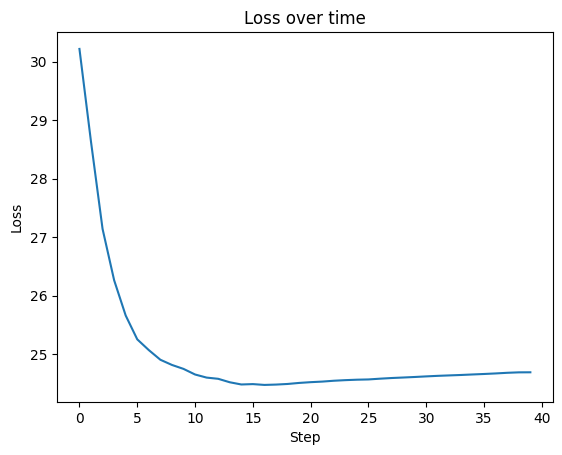

In [12]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss over time")

法1和法2的本质区别在于：法1首先从模型中获取噪声，然后再对x进行更新，但是这样的后果就是：如果引导强度过大，模型在引导函数的驱使下将显著趋向于引导颜色。  
而法2则直接先设置x的计算图需要梯度，并得到噪声后再进行对x的更新，这就使得x在模型的引导中时，梯度信息也会发生显著变化，这样不至于出现明显的色调变化。